[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ninarina12/DiffusionModels/blob/master/DDPM/DDPM.ipynb)

# Denoising Diffusion Probabilistic Models (DDPM)

A diffusion probabilistic model is a parameterized Markov chain trained to produce samples matching the data after a finite time. Transitions of this chain learn to reverse a diffusion (forward) process, which is a Markov chain that gradually adds (Gaussian) noise to the data until the signal in the data is destroyed [1,2]. The following tutorial is adapted from the indicated References.

<img src="ddpm.png" width="800"/>

## Background

### Forward (noising) process
The forward process adds noise to the data for $T$ timesteps. Given $x_0 \sim q(x_0)$ (the real data distribution), the data at subsequent times $t$ is made progressively more noisy according to,

$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t \mathbf{I})$$
$$q(x_{1:T} | x_0) = \prod_{t=1}^{T}q(x_t | x_{t-1})$$

where $\beta_1,...,\beta_T$ is the variance schedule.

Because the distributions are normal, we can mathematically derive the distribution of any intermediate value in the forward process given the initial data point, allowing us to sample $x_t$ at *any* timestep $t$ directly from,

$$\boxed{q(x_t|x_0) = \mathcal{N} ( x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} )} \tag{1}$$

where $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^{t}\alpha_s$.

### Reverse (denoising) process
If we could reverse the above process and sample from $q(x_{t-1} | x_t)$, we would be able to recreate the true sample from a Gaussian noise input [3]. (Note that if $\beta_t$ is small enough, $q(x_{t-1} | x_t)$ will also be Gaussian.) However, this distribution is generally unknown primarily because it depends on the entire data distribution. Specifically, from Bayes' theorem,

$$q(x_{t-1} | x_t) \propto q(x_t | x_{t-1})q(x_{t-1})$$
$$q(x_{t-1}) = \int q(x_{t-1} | x_0)q(x_0)dx_0$$

Computing $q(x_{t-1})$ requires integrating over all possible configurations of $x_0$, making it computationally intractable.

Instead, we can try to learn a model to approximate the necessary conditional probabilities and run the reverse diffusion process. In this case, the reverse process removes noise from a given sample $p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$ over the course of $T$ time steps according to,

$$p_\theta(x_{t-1} | x_t) = \mathcal{N}\big(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t) \big)$$
$$p_\theta(x_{0:T}) = p(x_T)\prod_{t=1}^{T}p_\theta(x_{t-1} | x_t)$$

where $\theta$ are trainable weights.

### Optimization problem
This setup is quite similar to that of a variational autoencoder and likewise uses a variational lower bound to optimize the negative log-likelihood (see [3] for a more detailed discussion),

$$\mathbb{E}[-\log p_\theta(x_0)] \leq \mathbb{E}_q \Big[ -\log \frac{p_\theta(x_{0:T})}{q(x_{1:T} | x_0)} \Big] = L$$

Through some mathematical manipulation, the loss $L$ can be rewritten as,

$$ L = \mathbb{E}_q \Big[ D_{KL}(q(x_T | x_0) || p(x_T)) + \sum_{t=2}^T D_{KL}(q(x_{t-1} | x_t, x_0) || p_\theta(x_{t-1} | x_t)) - \log p_\theta(x_0 | x_1) \Big] $$

Every term except the last compares two Gaussian distributions and can therefore be computed in closed form. The first term is constant given constant variance schedule. The last term is approximated by Ho et al. using a separate discrete decoder derived from $\mathcal{N}(x_0; \mu_\theta(x_1, 1), \Sigma_\theta(\mathbf{x}_1, 1))$, but in practice this will be captured by the simplified loss (introduced at the end). Thus, the main term we need to compute is $L_{t-1} = D_{KL}(q(x_{t-1} | x_t, x_0) || p_\theta(x_{t-1} | x_t))$.

#### The forward process term
First, the forward process posterior conditioned by $x_0$ (which is tractable) is (see [3] for a detailed derivation involving Bayes' rule),

$$ q(x_{t-1} | x_t, x_0) = \mathcal{N}(x_{t-1}; \tilde{\mu}_t(x_t, x_0), \tilde{\beta}_t \mathbf{I})$$

where,
$$ \tilde{\mu}_t(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t} x_0 + \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t $$

$$ \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t $$

Given $x_0$ and a noise $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, $x_t$ is obtained from $q(x_t|x_0)$ (Equation 1) as,

$$x_t(x_0, \epsilon) = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon \rightarrow x_0 = \frac{1}{\bar{\alpha}_t} \Big( x_t(x_0, \epsilon) - \sqrt{1 - \bar{\alpha}_t} \epsilon \Big)$$

which we can plug into the expression for $\tilde{\mu}_t(x_t, x_0)$ to obtain,

$$ \tilde{\mu}_t(x_t, x_0) = {\frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon \Big)}$$

#### The reverse process term
Recall that

$$p_\theta(x_{t-1} | x_t) = \mathcal{N}\big(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t) \big)$$

At this point, Ho et al. [2] choose $\Sigma_\theta(x_t, t)$ to be an untrained, time-dependent constant, $\Sigma_\theta(x_t, t) = \sigma_t^2 \mathbf{I}$. They find that the choice $\sigma_t^2 = \beta_t$ and $\sigma_t^2 = \tilde{\beta}_t$ yield similar results. (The implementation below uses $\sigma_t^2 = \beta_t$.) Thus, we have,

$$p_\theta(x_{t-1} | x_t) = \mathcal{N}\big(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 \mathbf{I} \big)$$

This means that we can simplify the closed form expression of $D_{KL}(q(x_{t-1} | x_t, x_0) || p_\theta(x_{t-1} | x_t)$ as,

$$ L_{t-1}  = \mathbb{E}_{x_0, \epsilon} \Big[\frac{1}{2 \sigma_t^2} \| {\tilde{\mu}_t(x_t, x_0)} - {\mu_\theta(x_t, t)} \|^2 \Big] + \text{ a constant}$$

This suggests that the most straightforward parameterization of $\mu_\theta(x_t, t)$ is a model that predicts $\tilde{\mu}_t(x_t, x_0)$. Since $x_t$ is available as input to the model, we can choose to parameterize $\mu_\theta(x_t, t)$ as,

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \Big(x_t - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big)$$

where $\epsilon_\theta(x_t, t)$ is the only trainable part, intended to predict the true $\epsilon$. Thus,

$$\boxed{p_\theta(x_{t-1} | x_t) = \mathcal{N}\big(x_{t-1}; \frac{1}{\sqrt{\alpha_t}} \Big(x_t - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big), \sigma_t^2 \mathbf{I} \big)} \tag{2}$$

Substituting in all our parameterizations and simplifying, we finally get,

$$ L_{t-1} = \mathbb{E}_{x_0, \epsilon} \Big[\frac{ \beta_t^2 }{2 \sigma_t^2 \alpha_t (1 - \bar{\alpha}_t)} \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \Big] $$

The final step taken by Ho et al. [2] is to introduce the "simplified loss", which is just,

$$\boxed{ L_\text{simple} = \mathbb{E}_{t, x_0, \epsilon} \Big[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \Big] } \tag{3}$$

This loss discards the weighting applied to each term and thereby increases the weight given to higher $t$ (which have higher noise levels), which is empirically found to increase sample quality. When $t=1$, this loss minimizes $- \log p_\theta(x_0 | x_1)$ as we wanted, and minimizes $L_{t-1}$ for $t > 1$.

## Workflow
### Training
1. Instantiate the $\epsilon_\theta$ model; the example below uses a type of UNet model.
2. Predefine the number of time steps $T$ and the variance schedule $\beta_1,...,\beta_T$
3. Get a batch of noise-free images
4. Get a random $t$ for each image in the batch - this will determine how noisy each image in the batch will be
5. Sample the true noise $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ for each image
6. Take a sample $x_t$ from $q(x_t|x_0)$ (Equation 1)
   - Compute the mean and variance from the variance schedule
   - Take a sample using the computed mean and variance and the true noise input
7. Predict the noise with the $\epsilon_\theta$ model using $x_t$ and $t$ as inputs.
8. Compute the mean squared error between the true and predicted noise (Equation 3)

### Inference
1. Get a batch of random, noisy images $x_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
2. Iteratively, from $t=T$ to $t=0$, take a sample from $p_\theta(x_{t-1}|x_t)$ (Equation 2)
    - Predict the noise using the trained $\epsilon_\theta(x_t, t)$
    - Compute the mean using the predicted noise and variance schedule, and the variance using the variance schedule
    - Take a random sample from $\mathcal{N}(\mathbf{0}, \mathbf{I})$ to randomly sample from the distribution
    - Feed the sampled $x_{t-1}$ back into the loop to serve as the $x_t$ in the next iteration
3. Return the denoised images $x_0$

<img src="workflow.png" width="1200"/>

## References
[1] **Original paper:** Sohl-Dickstein, Jascha, et al. "Deep unsupervised learning using nonequilibrium thermodynamics." *International conference on machine learning.* PMLR, 2015.

[2] **Most well-known and cited paper:** Ho, Jonathan, Ajay Jain, and Pieter Abbeel. "Denoising diffusion probabilistic models." *Advances in neural information processing systems* 33 (2020): 6840-6851.

[3] **A helpful blog post:** https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

[4] **Example implementation:** https://nn.labml.ai/diffusion/ddpm/index.html

<img src="training.gif" width="500"/>

In [3]:
# On Colab only:
!git clone https://github.com/ninarina12/DiffusionModels.git
%cd DiffusionModels/DDPM

## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from typing import Optional, Tuple
from unet import UNet

### Load MNIST dataset

In [2]:
# Define transformations for the MNIST dataset with 32x32 images
img_size = 32
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Define the sizes for train and test splits
train_size = int(0.8 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size

# Split the dataset into train and test sets
train_dataset, test_dataset = random_split(mnist_dataset, [train_size, test_size])

# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

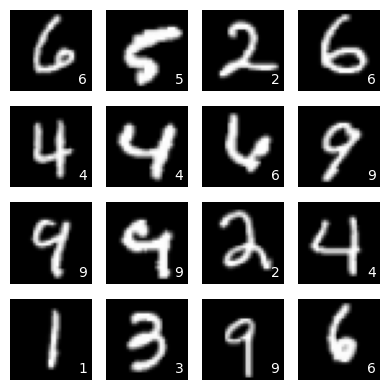

In [48]:
# Function to display images in a grid
def show_images(axes, images, labels=None):
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.axis('off')
            if labels is not None:
                ax.text(0.95, 0.05, str(labels[i].item()), color='white', ha='right', va='bottom', transform=ax.transAxes)

# Plot some examples from the training dataset
images, labels = next(iter(train_loader))

# Show first 16 images
sample_size = 16
images = images[:sample_size]
fig, axes = plt.subplots(4, 4, figsize=(4,4))
show_images(axes, images, labels=labels)
fig.tight_layout()

### Define diffusion process

In [4]:
class DenoiseDiffusion:
    """
    Denoising diffusion process
    """

    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        """
        eps_model: the trainable epsilon_theta(x_t, t) noise model
        n_steps: T
        device: the device on which to store constants (e.g., betas and alphas)
        """
        super().__init__()
        self.eps_model = eps_model # All trainable weights are in eps_model

        # Create linearly increasing variance schedule
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)

        # alpha_t = 1 - beta_t
        self.alpha = 1. - self.beta
        
        # alpha_bar_t = prod_{s=1}^t alpha_s
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        
        # n_steps = T
        self.n_steps = n_steps
        
        # sigma^2 = beta
        self.sigma2 = self.beta

    def gather(self, consts: torch.Tensor, t: torch.Tensor):
        """Gather (extract) the values in the array of constants for the sampled t's and reshape to feature map shape"""
        c = consts.gather(-1, t) # Equivalent to c = consts[t]
        return c.reshape(-1, 1, 1, 1) # (batch_size, channels, img_size, img_size)
    
    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Define the distribution (mean and variance) of q(x_t|x_0) (Equation 1)
        """

        # Gather alpha_t and compute sqrt(alpha_bar_t) * x_0
        mean = self.gather(self.alpha_bar, t) ** 0.5 * x0
        
        # (1-alpha_bar_t) * I
        var = 1 - self.gather(self.alpha_bar, t)

        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        """
        Take a random sample from q(x_t|x_0) (Equation 1)
        """

        # Sample epsilon ~ N(0,I) - when given (during training), this will be the true noise to predict
        if eps is None:
            eps = torch.randn_like(x0)

        # Get q(x_t|x_0)
        mean, var = self.q_xt_x0(x0, t)
        
        # Sample from q(x_t|x_0)
        return mean + (var ** 0.5) * eps

    def p_xt_1_xt(self, xt: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Define the distribution (mean and variance) of p_theta(x_{t-1}|x_t) (Equation 2)
        """
        
        # Predict epsilon_theta(x_t, t)
        eps_theta = self.eps_model(xt, t)
        
        # Gather alpha_bar_t
        alpha_bar = self.gather(self.alpha_bar, t)
        
        # alpha_t
        alpha = self.gather(self.alpha, t)
        
        # beta_t / sqrt(1 - alpha_bar_t) = (1 - alpha_t) / sqrt(1 - alpha_bar_t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        
        # mu = 1 / sqrt(alpha_t) * (x_t - beta_t / sqrt(1 - alpha_bar_t) * epsilon_theta(x_t, t))
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        
        # sigma^2
        var = self.gather(self.sigma2, t)

        return mean, var
        
    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        """
        Take a random sample from p_theta(x_{t-1}|x_t) (Equation 2)
        """

        # Get p_theta(x_{t-1}|x_t)
        mean, var = self.p_xt_1_xt(xt, t)

        # Take a random sample ~ N(0,I)
        eps = torch.randn(xt.shape, device=xt.device)
        
        # Sample from p_theta(x_{t-1}|x_t)
        return mean + (var ** .5) * eps

    def denoise(self, x: torch.Tensor, times: Optional[int] = 1):
        """
        ### Denoise images
        """
        batch_size = x.shape[0]

        times = np.linspace(0, self.n_steps - 1, times)
        images = []
            
        with torch.no_grad():
            # Remove noise for T steps
            for _t in range(self.n_steps):
                # t
                t = self.n_steps - _t - 1
                
                # Sample from p_theta(x_{t-1}|x_t)
                x = self.p_sample(x, x.new_full((batch_size,), t, dtype=torch.long))

                if t in times:
                    images.append(x.cpu())
        
        if len(times) == 1:
            images = images[0]
            
        return images
    
    def loss(self, x0: torch.Tensor):
        """
        Simplified Loss (Equation 3)
        """
        # Get batch size
        batch_size = x0.shape[0]
        
        # Get random t for each sample in the batch
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        # Sample the true noise, epsilon ~ N(0,I)$
        noise = torch.randn_like(x0)

        # Sample x_t from q(x_t|x_0)
        xt = self.q_sample(x0, t, eps=noise)
        
        # Get the predicted noise epsilon_theta
        eps_theta = self.eps_model(xt, t)

        # MSE loss
        return F.mse_loss(noise, eps_theta)

### Specify hyperparameters of the noise model and optimizer

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('Using device', device)
      
# Number of channels in the image
img_channels = images.shape[1]

# Image size
img_size = images.shape[-1]

# Number of channels in the initial feature map
n_channels = 64

# The list of channel numbers at each resolution.
# The number of channels is `channel_multipliers[i] * n_channels`
channel_multipliers = [1, 2, 2, 4]

# The list of booleans that indicate whether to use attention at each resolution
is_attention = [False, False, False, True]

# Number of time steps T
n_steps = 1000

# Learning rate
learning_rate = 2e-5

# Checkpointing
chkpt_per_batch = 10
chkpt = len(train_loader.dataset)//batch_size//chkpt_per_batch

Using device cpu


In [10]:
# Instantiate noise model
eps_model = UNet(image_channels=img_channels,
                 n_channels=n_channels,
                 ch_mults=channel_multipliers,
                 is_attn=is_attention).to(device)
print("Number of parameters:", sum(p.numel() for p in eps_model.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(eps_model.parameters(), lr=learning_rate)
model_path = "ddpm.pt"

if os.path.exists(model_path):
    checkpoint = torch.load(model_path, weights_only=True, map_location=device)
    start_epoch = checkpoint['epochs']
    eps_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    noise = checkpoint['noise']
    loss_history = checkpoint['loss_history']
    image_history = checkpoint['image_history']

else:
    start_epoch = 0
    noise = torch.randn([sample_size, img_channels, img_size, img_size], device=device) # x_T
    loss_history = []
    image_history = []

# Define diffusion process with specified noise model
ddpm = DenoiseDiffusion(eps_model, n_steps, device)

Number of parameters: 167775681


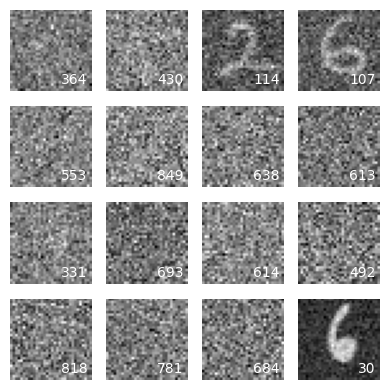

In [49]:
# Plot (partially) noised images
t = torch.randint(0, n_steps, (sample_size,), device=device, dtype=torch.long)
images_noised = ddpm.q_sample(images.to(device), t)
fig, axes = plt.subplots(4, 4, figsize=(4,4))
show_images(axes, images_noised.cpu(), labels=t)
fig.tight_layout()

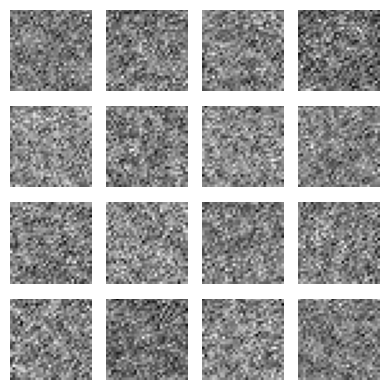

In [12]:
# Plot fully denoised images
images_new = ddpm.denoise(noise)
fig, axes = plt.subplots(4, 4, figsize=(4,4))
show_images(axes, images_new.cpu())
fig.tight_layout()

### Train

In [ ]:
# Training loop
eps_model.train()
num_epochs = 15

for epoch in range(start_epoch, start_epoch + num_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        loss = ddpm.loss(inputs)
        loss.backward()
        optimizer.step()

        if i % chkpt == 0:
            print(f"Epoch: {epoch + 1}, Batch: {i}, Loss: {loss.item()}")

            loss_history.append(loss.item())
            
            eps_model.eval()
            image_history.append(ddpm.denoise(noise).cpu())
            eps_model.train()
            
            torch.save({'epochs': epoch + 1,
                        'model_state_dict': eps_model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'noise': noise,
                        'loss_history': loss_history,
                        'image_history': image_history
                       }, model_path)
            
loss_history.append(loss.item())

eps_model.eval()
image_history.append(ddpm.denoise(noise).cpu())

torch.save({'epochs': epoch + 1,
            'model_state_dict': eps_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'noise': noise,
            'loss_history': loss_history,
            'image_history': image_history
           }, model_path)

### Visualize results

In [20]:
# Load trained model
model_path = "models/ddpm_pretrained.pt" # "ddpm.pt"
epochs = checkpoint['epochs']
checkpoint = torch.load(model_path, weights_only=True, map_location=device)
eps_model.load_state_dict(checkpoint['model_state_dict'])
noise = checkpoint['noise']
loss_history = checkpoint['loss_history']
image_history = checkpoint['image_history']

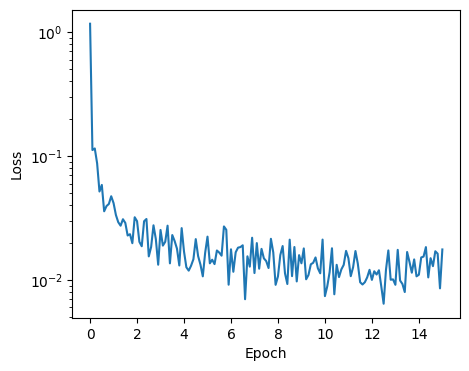

In [23]:
# Plot loss
step = epochs / (len(loss_history) - 1)
iterations = np.arange(0, epochs + step, step)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(iterations, loss_history)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')

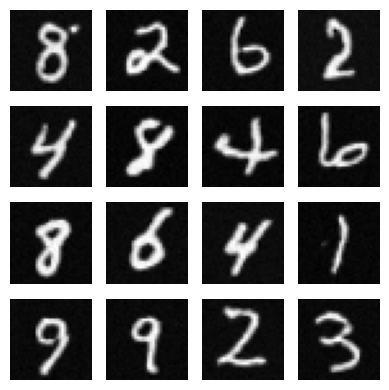

In [12]:
# Plot fully denoised images
eps_model.eval()
images_new = ddpm.denoise(noise)
fig, axes = plt.subplots(4, 4, figsize=(4,4))
show_images(axes, images_new.cpu())
fig.tight_layout()

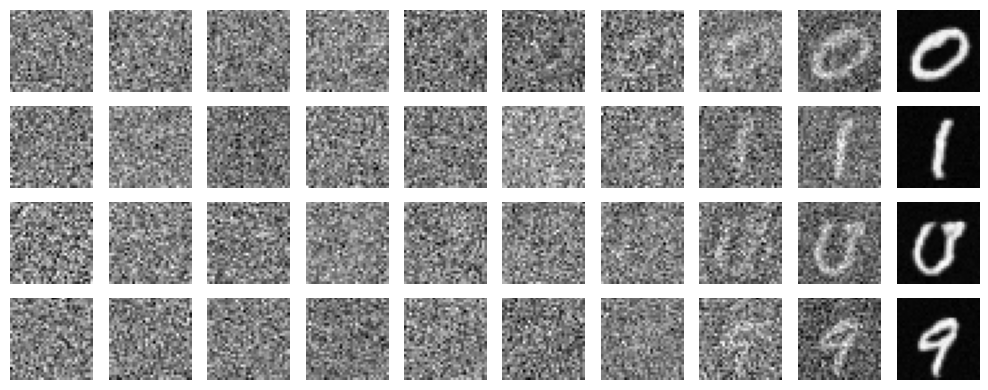

In [13]:
# Plot progressively denoised images
times = 10
images_new = ddpm.denoise(noise, times=times)

fig, ax = plt.subplots(4, times, figsize=(times,4))
for i in range(4):
    for t in range(times):
        ax[i,t].imshow(images_new[t][i].squeeze(), cmap='gray')
        ax[i,t].axis('off')
fig.tight_layout()

### (Optional) Animate training history

In [ ]:
from matplotlib.animation import FuncAnimation

def animate_training(iterations, loss_history, image_history):
    n_frames = len(loss_history)
    
    # Initialize figure
    fig = plt.figure(figsize=(5,7))
    fig.tight_layout()
    
    # Create a grid for images (4x4)
    grid_axes = []
    for i in range(4):
        for j in range(4):
            ax = plt.subplot2grid((5, 4), (i, j))  # 4 rows for grid, 1 row for loss plot
            ax.axis('off')
            grid_axes.append(ax)
    
    # Create the loss plot at the bottom
    loss_ax = plt.subplot2grid((5, 4), (4, 0), colspan=4)
    loss_ax.set_xlim(0 - 0.5, iterations.max() + 0.5)
    loss_ax.set_ylim(0.5*min(loss_history), 2*max(loss_history))
    loss_ax.set_yscale('log')
    loss_ax.set_xlabel('Epochs')
    loss_ax.set_ylabel('Loss')
    loss_line, = loss_ax.plot([], [], color='black', lw=1)
    
    # Update function for animation
    def update(frame):
        # Update grid images
        for idx, ax in enumerate(grid_axes):
            ax.clear()
            ax.imshow(image_history[frame][idx].squeeze(), cmap='gray')
            ax.axis('off')
    
        # Update loss plot
        loss_line.set_data(iterations[:frame + 1], loss_history[:frame + 1])
        return grid_axes + [loss_line]
    
    # Animation
    ani = FuncAnimation(fig, update, frames=n_frames, interval=200, blit=False)
    plt.close(fig)
    
    # Save animation or display
    ani.save('training.gif')

In [ ]:
animate_training(iterations, loss_history, image_history)